<center><a style="font-size: 25pt; font-weight: bold">Natural Language Processing with Disaster Tweets</a></center>
<br/>
<center><a style="font-size: 18pt; font-weight: bold">Binary Classification on Tweets texts</a></center>
<br/>

<span style="color:magenta">Group Names:</span>

* Zhe HUANG
* Lanshi FU
* Pierre QIU

## 1 Introduction


### 1.1 Description

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).  

In this Kaggle competition, we aim to build a machine learning model that predicts which Tweets are about real disasters and which Tweets aren’t. We have access to a dataset of 10,000 tweets that were hand classified.

This is a binary classification task on (relatively) short texts; The size of dataset is very tiny. 

### 1.2 Preparation

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, pipeline

import fasttext

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

from simpletransformers.classification import ClassificationModel

In [2]:
nltk.download('stopwords')
StopWords = set(stopwords.words('English'))

nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qiu87\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qiu87\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.3 Have a look at the data

Our data contains 4 columns, keyword, location, text and target:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
train = pd.read_csv("./Data/train.csv", index_col='id')
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv("./Data/test.csv", index_col='id')
test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 2 Data Preprocessing

### 2.1 Drop the duplicate rows in training set

In [5]:
train.shape

(7613, 4)

We have 7613 Tweets as training data. The first thing we should do is to drop the duplicate rows.

In [6]:
print("There are", np.sum(train.duplicated()), "duplicate rows in the training set.")

There are 52 duplicate rows in the training set.


In [7]:
train = train.drop_duplicates()
train.shape

(7561, 4)

After dropping the duplicate rows, there remain 7561 samples.  
This is a relatively small number, compared with millions of Tweets online. As a result, our model may not be generalizable enough.

### 2.2 Check for completeness of training data

In [8]:
print(np.sum(train['keyword'].isna()), "Tweets have no keywords")
print(np.sum(train['location'].isna()), "Tweets have no location")
print(np.sum(train['text'].isna()), "Tweets have no text")
print(np.sum(train['text'].isna()), "Tweets have no target")

61 Tweets have no keywords
2500 Tweets have no location
0 Tweets have no text
0 Tweets have no target


### 2.3 Check for balance of targets

In [9]:
counts_train = train['target'].value_counts()
counts_train

0    4322
1    3239
Name: target, dtype: int64

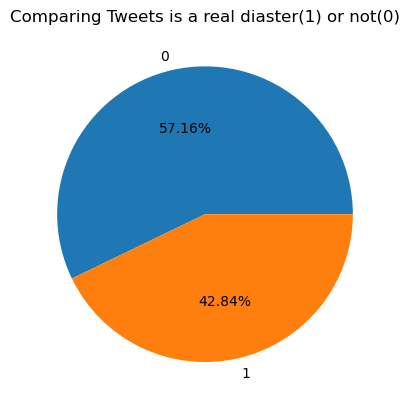

In [10]:
plt.pie(x=counts_train, labels=counts_train.index, autopct='%.2f%%')
plt.title("Comparing Tweets is a real diaster(1) or not(0)")
plt.show()

There are 3239(42.82%) diaster Tweets and 4322(57.16%) non-diaster Tweets.  
Thus we have an about 3:4 class balance of targets. This is not perfect but still can be used for training.

### 2.4 Text Cleaning

In [11]:
def clean_text(text):
    """
    This function is to clean the Tweet texts.

    :param text: Tweet text
    :return temp: cleaned Tweet text
    """
    temp = text.lower() # make text lowercase
    temp = re.sub('\n', ' ' , temp) #remove \n
    temp = re.sub('\'', '', temp) #remove \'
    temp = re.sub('-', ' ', temp) #remove -
    temp = re.sub(r'(http|https|pic.)\S', ' ', temp) #remove links
    temp = re.sub(r'[^\w\s]', ' ', temp) #remove symbols
    
    return temp


def remove_stopwords(text):
    """
    This function is to remove stopwords. Stopwords are those those words unuseless like 'they', 'am', 'been', 'about'.
    
    :param text: Tweet text with stopwords
    :return temp: Tweet text without stopwords
    """
    tokenized_words = word_tokenize(text) # word tokenization
    temp = [word for word in tokenized_words if word not in StopWords] # remain those words who are not stopwords
    temp = ' '.join(temp) # convert tokenized to text
    
    return temp

By cleaning the data, the remained texts become more informative.

In [12]:
train['clean'] = train['text'].apply(clean_text)
train['clean'] = train['clean'].apply(remove_stopwords)

train.head()

,keyword,location,text,target,clean
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [13]:
test['clean'] = test['text'].apply(clean_text)
test['clean'] = test['clean'].apply(remove_stopwords)

test.head()

,keyword,location,text,clean
id,,,,
0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan


### 2.5 Tokenization(with Lemmatization and Stemming)

In [14]:
def token_normalization(tokens):
    """
    This function is to convert tokens into its base form. First Lemmatization and then Stemming.

    :param tokens: token got by nltk.tokenize.word_tokenize
    :parma temp: tokens/words in original form
    """
    # Lemmatizer: mainly cats -> cat
    lemmatizer=nltk.stem.WordNetLemmatizer()
    temp = [lemmatizer.lemmatize(token) for token in tokens]

    # Stemmer: mainly talked -> talk
    stemmer = nltk.stem.PorterStemmer()
    temp = [stemmer.stem(token) for token in temp]

    return temp

In [15]:
train['tokens'] = train['clean'].apply(word_tokenize)
train['tokens'] = train['tokens'].apply(token_normalization)

train.head()

,keyword,location,text,target,clean,tokens
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[deed, reason, earthquak, may, allah, forgiv, u]"
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, rong, sask, canada]"
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,"[resid, ask, shelter, place, notifi, offic, ev..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...,"[13, 000, peopl, receiv, wildfir, evacu, order..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [16]:
test['tokens'] = test['clean'].apply(word_tokenize)
test['tokens'] = test['tokens'].apply(token_normalization)

test.head()

,keyword,location,text,clean,tokens
id,,,,,
0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,"[happen, terribl, car, crash]"
2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,"[heard, earthquak, differ, citi, stay, safe, e..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,"[forest, fire, spot, pond, goos, flee, across,..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,"[apocalyps, light, spokan, wildfir]"
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,"[typhoon, soudelor, kill, 28, china, taiwan]"


### 2.6 Last Processing

We now remove those unused information in the two dataframes, only remain id, tokens (and targets in training set).

In [17]:
train = train.drop(columns=['keyword', 'location', 'clean', 'text'])

In [18]:
test = test.drop(columns=['keyword', 'location', 'clean', 'text'])

In order to do vectorization, we convert tokens into texts again.

In [19]:
train['texts'] = train['tokens']
for i in train.index:
    train['texts'][i] = " ".join(token for token in train['tokens'][i])

train.head()

C:\Users\qiu87\AppData\Local\Temp\ipykernel_13868\2213565989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['texts'][i] = " ".join(token for token in train['tokens'][i])


,target,tokens,texts
id,,,
1,1,"[deed, reason, earthquak, may, allah, forgiv, u]",deed reason earthquak may allah forgiv u
4,1,"[forest, fire, near, la, rong, sask, canada]",forest fire near la rong sask canada
5,1,"[resid, ask, shelter, place, notifi, offic, ev...",resid ask shelter place notifi offic evacu she...
6,1,"[13, 000, peopl, receiv, wildfir, evacu, order...",13 000 peopl receiv wildfir evacu order califo...
7,1,"[got, sent, photo, rubi, alaska, smoke, wildfi...",got sent photo rubi alaska smoke wildfir pour ...


In [20]:
test['texts'] = test['tokens']
for i in test.index:
    test['texts'][i] = " ".join(token for token in test['tokens'][i])

test.head()

,tokens,texts
id,,
0,"[happen, terribl, car, crash]",happen terribl car crash
2,"[heard, earthquak, differ, citi, stay, safe, e...",heard earthquak differ citi stay safe everyon
3,"[forest, fire, spot, pond, goos, flee, across,...",forest fire spot pond goos flee across street ...
9,"[apocalyps, light, spokan, wildfir]",apocalyps light spokan wildfir
11,"[typhoon, soudelor, kill, 28, china, taiwan]",typhoon soudelor kill 28 china taiwan


In [21]:
#We split the train set to get a validation set
train_xs, valid_xs, train_ys, valid_ys = model_selection.train_test_split(
    train["texts"], train["target"], test_size=0.3, random_state=0, shuffle=True
)

## 3 Baseline approach I with Word2vec 

### 3.1 Find the best model  

We do grid search in order to find the best vectorizer and the best classification model along with their best hyperparameters.

#### 3.1.1 Grid Search Preparations

In [22]:
# grid search set for hyperparameters of SVC

ngram_range=[(1, 1),(1,2),(1,3)]
max_features =  [500,1000,1500,2000,5000,10000]
stop_words =  [None,'english']

param_grid_SVC = {
              "vectorizer__max_features" : max_features,
              "vectorizer__stop_words" : stop_words,
              "vectorizer__ngram_range" : ngram_range,
              "model__tol" : [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3],
              "model__C" : [0.001,0.1,1,2],
              "model__max_iter" : [10000]
            }

# grid search set for hyperparameters of RandomForest

n_estimators =  np.arange(1, 101, 20) 
max_depth =  np.arange(1, 101, 20)
min_samples_split = [2,4,8,16]
min_samples_leaf = [1,2,4,8]

param_grid_RF = {
              "vectorizer__max_features" : max_features,
              "vectorizer__stop_words" : stop_words,
              "vectorizer__ngram_range" : ngram_range,
              "model__n_estimators":n_estimators,
              "model__max_depth":max_depth,
              "model__min_samples_split":min_samples_split,
              "model__min_samples_leaf":min_samples_leaf
            }

In [23]:

pipe_Tfidf_SVC = pipeline.Pipeline( steps= [ ('vectorizer', TfidfVectorizer()) , ('model', LinearSVC()) ] )
pipe_Count_SVC = pipeline.Pipeline( steps= [('vectorizer', CountVectorizer()),('model', LinearSVC())])
pipe_Tfidf_RF = pipeline.Pipeline( steps= [('vectorizer', TfidfVectorizer()),('model', RandomForestClassifier())])
pipe_Count_RF = pipeline.Pipeline(  steps= [('vectorizer', CountVectorizer()),('model', RandomForestClassifier())])

#### 3.1.2 Grid Search Process

In [24]:
%%time
# Tfidf Vectorizer and SVM model 

Tfidf_SVC = model_selection.GridSearchCV(
    pipe_Tfidf_SVC, param_grid_SVC, n_jobs=-1, verbose=3, cv=5
)
Tfidf_SVC.fit(train_xs, train_ys)

print(Tfidf_SVC.best_estimator_)
print('best score:')
print(Tfidf_SVC.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('model', LinearSVC(C=0.1, max_iter=10000, tol=1e-08))])
best score:
0.8002668637352711
Wall time: 1min 26s


In [25]:
%%time
# CounterVectorizer and SVM model

Count_SVC = model_selection.GridSearchCV(
    pipe_Count_SVC, param_grid_SVC, n_jobs=-1, verbose=3, cv=5
)
Count_SVC.fit(train_xs, train_ys)

print(Count_SVC.best_estimator_)
print('best score:')
print(Count_SVC.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('model', LinearSVC(C=0.1, max_iter=10000, tol=1e-08))])
best score:
0.7927064980873278
Wall time: 1min 45s


In [26]:
%%time
# CounterVectorizer and RandomForest model

Count_RF = model_selection.GridSearchCV(
    pipe_Count_RF, param_grid_RF, n_jobs=-1, verbose=3, cv=5
)
Count_RF.fit(train_xs, train_ys)

print(Count_RF.best_estimator_)
print('best score:')
print(Count_RF.best_score_)

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits
Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=1500, ngram_range=(1, 3))),
                ('model',
                 RandomForestClassifier(max_depth=81, min_samples_split=16,
                                        n_estimators=81))])
best score:
0.7876053843998065
Wall time: 32min 32s


In [27]:
%%time
# Tfidf Vectorizer and RandomForest model

Tfidf_RF = model_selection.GridSearchCV(
    pipe_Tfidf_RF, param_grid_RF, n_jobs=-1, verbose=3, cv=5
)
Tfidf_RF.fit(train_xs, train_ys)

print(Tfidf_RF.best_estimator_)
print('best score:')
print(Tfidf_RF.best_score_)
predictions = Tfidf_RF.best_estimator_.predict(valid_xs)

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1500)),
                ('model',
                 RandomForestClassifier(max_depth=81, min_samples_leaf=2,
                                        min_samples_split=4,
                                        n_estimators=61))])
best score:
0.7864709903946906
Wall time: 34min 5s


### 3.2 Test with the best hyperparameters

We found that the best combination of vectorizer and classification model is Tfidf_SVC!

In [28]:
predictions = Tfidf_SVC.best_estimator_.predict(test["texts"])

### 3.4 Evaluation

In [29]:
# Creating submission data.

submission = pd.read_csv('./Data/sample_submission.csv')
submission['target'] = predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [30]:
# Saving submission to '.csv' file:

submission.to_csv('./Data/submission_Word2vec.csv', index=False, header=True)

We uploaded **submission_Word2vec.csv** into kaggle and got a score of **0.78424**.

## 4 Baseline approach II with Fasttext

### 4.1 Generate text file for Fasttext

In [31]:
# generate train set for fasttext
with open("./Data/train_fasttext.txt", 'w',encoding='utf-8') as f:
    for i in train.index:
        line = "__label__%d %s\n" % (train["target"][i], train["texts"][i])
        f.write(line)
    f.close()

# generate test set for fasttext
with open("./Data/test_fasttext.txt", 'w',encoding='utf-8') as f:
    for i in test.index:
        line = "%s\n" % test["texts"][i]
        f.write(line)
    f.close()
    

In [32]:
print("The first several lines of train_fasttext.txt:\n")
with open("./Data/train_fasttext.txt", 'r',encoding='utf-8') as f:
    for i in range(5):
        print(f.readline(), end='')
    f.close()

print('\nThe first several lines of test_fasttext.txt:\n')
with open("./Data/test_fasttext.txt", 'r',encoding='utf-8') as f:
    for i in range(5):
        print(f.readline(), end='')
    f.close()

The first several lines of train_fasttext.txt:

__label__1 deed reason earthquak may allah forgiv u
__label__1 forest fire near la rong sask canada
__label__1 resid ask shelter place notifi offic evacu shelter place order expect
__label__1 13 000 peopl receiv wildfir evacu order california
__label__1 got sent photo rubi alaska smoke wildfir pour school

The first several lines of test_fasttext.txt:

happen terribl car crash
heard earthquak differ citi stay safe everyon
forest fire spot pond goos flee across street save
apocalyps light spokan wildfir
typhoon soudelor kill 28 china taiwan


### 4.2 Grid Search

In [33]:
#read the fasttext file.
with open("./Data/train_fasttext.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    f.close()

train_xs= []
train_ys = []
for line in lines:
    label, text = line.strip().split(' ', 1)
    train_ys.append(label)
    train_xs.append(text)

# Here we want a dataframe for grid search below
df = pd.DataFrame(columns=['targets','texts'])
df["targets"] = train_ys
df["texts"] = train_xs
df

,targets,texts
0,__label__1,deed reason earthquak may allah forgiv u
1,__label__1,forest fire near la rong sask canada
2,__label__1,resid ask shelter place notifi offic evacu she...
3,__label__1,13 000 peopl receiv wildfir evacu order califo...
4,__label__1,got sent photo rubi alaska smoke wildfir pour ...
...,...,...
7556,__label__1,two giant crane hold bridg collaps nearbi home...
7557,__label__1,aria_ahrari thetawniest control wild fire cali...
7558,__label__1,m1 94 01 04 utc 5km volcano hawaii co zdtoyd8ebj
7559,__label__1,polic investig e bike collid car littl portug ...


In [34]:
# range of hyperparameters
lrs =  [0.1, 0.5, 1.0, 2.0]
epochs = [5, 10, 15, 20 ,25]
wordNgrams = [1, 2, 3, 5]
kf = model_selection.KFold(n_splits=5) 

In [35]:
# Grid Search in order to find the best hyperparameters of fasttext.train_supervised()
import tempfile
import shutil

i = 0
estimators = pd.DataFrame(columns=['score','param'])
for lr in lrs:
    for epoch in epochs:
        for wordNgram in wordNgrams:
            #print(f"lr:{lr},epoch:{epoch},wordNgrams:{wordNgram}")
            metric_score = 0.0
            for train_idx, val_idx in kf.split(df):
                df_train = df.loc[train_idx]
                df_val = df.loc[val_idx]
                tmpdir = tempfile.mkdtemp()
                train_csv = tmpdir + '/cv_train_fasttext.txt'
                df_train.to_csv(train_csv, sep='\t', index=False, header=None, encoding='UTF-8')
                fast_model = fasttext.train_supervised(train_csv, epoch=epoch, lr=lr, wordNgrams=wordNgram, verbose=2, minCount=1)
                predictions = []
                for line in df_val["texts"]:
                    line = line.strip()
                    predictions.append(fast_model.predict(line)[0][0])
                predictions= np.array(predictions)
                score = len(predictions[predictions==df_val["targets"]])/len(predictions)
                metric_score += score
                shutil.rmtree(tmpdir, ignore_errors=True) 
            #print('Score:', metric_score / kf.n_splits)
            param = {}
            param["epoch"] = epoch
            param["wordNgrams"] = wordNgram
            param["lr"] = lr
            row={'score':metric_score / kf.n_splits,'param':param}
            estimators.loc[i] = row
            i+=1

In [36]:
print(f'Best score {estimators["score"].max()} witn {estimators[estimators["score"]==estimators["score"].max()]["param"].values}')

Best score 0.7645799892990903 witn [{'epoch': 25, 'wordNgrams': 3, 'lr': 0.5}]


### 4.2 Train with the best hyperparameters

In [37]:
model = fasttext.train_supervised(
        input="./Data/train_fasttext.txt", epoch=15, lr=0.1, wordNgrams=3
    )

### 4.3 Prediction

In [38]:
predictions = []
with open("./Data/test_fasttext.txt", 'r',encoding='utf-8') as f:
    for line in f.readlines():
        line = line.strip()
        predictions.append(int(model.predict(line)[0][0][-1]))

predictions[:5]

[1, 1, 1, 1, 1]

### 4.4 Evaluation

In [39]:
# Creating submission data.

submission = pd.read_csv('./Data/sample_submission.csv')
submission['target'] = predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [40]:
# Saving submission to '.csv' file:

submission.to_csv('./Data/submission_fasttext.csv', index=False, header=True)

We uploaded **submission_fasttext.csv** into kaggle and got a score of **0.80202**.

## 5 Advanced approach with Bert

### 5.1 Preprocess data

In [54]:
df = train[["texts"]]
df["pred_class"] = train["target"]
df.head()

C:\Users\qiu87\AppData\Local\Temp\ipykernel_13868\300826876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred_class"] = train["target"]


,texts,pred_class
id,,
1,deed reason earthquak may allah forgiv u,1
4,forest fire near la rong sask canada,1
5,resid ask shelter place notifi offic evacu she...,1
6,13 000 peopl receiv wildfir evacu order califo...,1
7,got sent photo rubi alaska smoke wildfir pour ...,1


### 5.2 Build Bert Model

We define a model from a pre-trained base(distilbert-base-uncased model).

In [55]:
# define hyperparameter
train_args ={"reprocess_input_data": False,
             "fp16":False,
             "num_train_epochs": 2}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "distilbert-base-uncased",
    num_labels=2,
    args=train_args,
    use_cuda=False
)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.2.attention.k_lin.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'distilbert.transformer.layer.3.ffn.lin1.bias', 'distilbert.transformer.layer.5.attention.k_lin.weight', 'distilbert.transformer.layer.3.ffn.lin2.bias', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.2.output_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.1.output_layer_norm.bias', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.0.sa

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


### 5.2 Train & Predict

In [56]:
model.train_model(df)

D:\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/946 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/946 [00:00<?, ?it/s]

(1892, 0.54629970622499)

In [57]:
predictions = model.predict(test["texts"].tolist())

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

### 5.3 Evaluation

In [58]:
# Creating submission data.

submission = pd.read_csv('./Data/sample_submission.csv')
submission['target'] = predictions[0]
submission.head(10)

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [59]:
# Saving submission to '.csv' file:

submission.to_csv('./Data/submission_bert.csv', index=False, header=True)

We uploaded **submission_bert.csv** into kaggle and got a score of **0.77934**.

## 6 Conclusion

### 6.1 What we succeed
* we first anylyse the trainning data and testing data, make sure that this dataset can be used to our classification task.
* we did the preprocessing of data which includes dropping the duplication of samples, cleaning the tweets texts, Lemmatization and Stemming,etc
* we used 3 different methodes to classifier the tweets: traditionel Word2vec, Fasttext and advanced bert whih is based on transformer
* we also used grid search to find the best hyperparameters for Word2vec method and Fasttext method
* we also uploaded several times our test result into 

### 6.2 What we failed
* We actually tried to create our own bert model with the pretrained huggingface model, which means we have to fine tune the first layer of the model. Since this is a little hard for our current level, we gave it up.
* We also tried to do grid search for the current used bert model but that failed too due to the time limit.
* At the very beginning, we tried different combinations of Lemmatization and Stemming; But it turns out that first Lemmatization and then Stemming is the best choice.

### 6.3 If we had more time
* We would establish our own burt model, but before that, we had to learn bert model step by step
* It's also worthy to see whether the result will become better if we delete several steps of preprocessing(as we know, the training and grid search takes time)
* Actually at the end we found that this dataset is too small and maybe we can try with a bigger tweets dataset.